# 栄養パターンに基づく口腔・上部消化管がん分類モデルの構築および評価3

In [2]:
%reset -f

# 概要

## パッケージインストール

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
!pip install statsmodels
from statsmodels.duration.hazard_regression import PHReg
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from decimal import Decimal, ROUND_HALF_UP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import os

## データの読み込み

In [4]:
# データの読み込み
merged_df5=pd.read_csv('merged_df5.csv')
merged_df5_a=pd.read_csv('merged_df5_a.csv')
merged_df5_b=pd.read_csv('merged_df5_b.csv')
adjusted_df=pd.read_csv('adjusted_df.csv')
merged_R=pd.read_csv('merged_R.csv')

## 栄養素の標準化¶

In [6]:
# 削除したい列名のリストを定義
columns_to_drop = ["ene", "prot", "carbo", "Na", "K", "Ca", "Fe", "carotene", "retiEQ", "VD", 
    "VE", "VB1", "VB2", "folate", "VC", "SFA", "MUFA", "chol", "SDF", "IDF", 
    "n3PUFA", "n6PUFA",
                  ]

# リストとして引数を渡し、削除を実行
merged_R_a = merged_R.drop(columns_to_drop, axis=1)

In [ ]:
# df1から'id1'列を抽出し、df2にインデックスをキーとして結合
adjusted_df = adjusted_df.join(merged_df5['id1'])
merged_df5_a = merged_df5_a.join(merged_df5['id1'])
merged_df5_b = merged_df5_b.join(merged_df5['id1'])
adjusted_df_R = pd.merge(merged_R_a, adjusted_df, on='id1', how='inner')

pd.set_option('display.max_columns', None)
display(adjusted_df_R)
pd.reset_option('display.max_columns')
adjusted_df=adjusted_df_R[['prot_trans_adj', 'carbo_trans_adj', 'Na_trans_adj', 'K_trans_adj', 'Ca_trans_adj', 'Fe_trans_adj', 'carotene_trans_adj', 'retiEQ_trans_adj', 'VD_trans_adj', 'VE_trans_adj', 'VB1_trans_adj', 'VB2_trans_adj', 'folate_trans_adj', 'VC_trans_adj', 'SFA_trans_adj', 'MUFA_trans_adj', 'chol_trans_adj', 'SDF_trans_adj', 'IDF_trans_adj', 'n3PUFA_trans_adj', 'n6PUFA_trans_adj']]
merged_df5_a_R = pd.merge(merged_R_a, merged_df5_a, on='id1', how='inner')
merged_df5_a=merged_df5_a_R[['ene', 'prot', 'carbo', 'Na', 'K', 'Ca', 'Fe', 'carotene', 'retiEQ', 'VD', 'VE', 'VB1', 'VB2', 'folate', 'VC', 'SFA', 'MUFA', 'chol', 'SDF', 'IDF', 'n3PUFA', 'n6PUFA']]
merged_df5_b_R = pd.merge(merged_R_a, merged_df5_b, on='id1', how='inner')
merged_df5_b=merged_df5_b_R[['ene_trans', 'prot_trans', 'carbo_trans', 'Na_trans', 'K_trans', 'Ca_trans', 'Fe_trans', 'carotene_trans', 'retiEQ_trans', 'VD_trans', 'VE_trans', 'VB1_trans', 'VB2_trans', 'folate_trans', 'VC_trans', 'SFA_trans', 'MUFA_trans', 'chol_trans', 'SDF_trans', 'IDF_trans', 'n3PUFA_trans', 'n6PUFA_trans']]

In [ ]:
adjusted_z_df=adjusted_df.copy()
print('Before:')
display(adjusted_z_df.describe(include='all'))

#Standardization of continuous variables
tempDF1 = adjusted_z_df.select_dtypes(include=np.number)#Take the continous variables
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
tempA = scaler.fit_transform(tempDF1)#Column direction
tempDF1 = pd.DataFrame(data=tempA, index=tempDF1.index, columns=tempDF1.columns)#Clean
tempDF2 = adjusted_z_df.select_dtypes(exclude=np.number)#Rescue the categorical variables
adjusted_z_df = pd.merge(tempDF1, tempDF2, left_index=True, right_index=True, how='left')
adjusted_z_df = adjusted_z_df.reset_index(drop=True)
print('After:')
display(adjusted_z_df)
display(adjusted_z_df.describe(include='all'))

## 調節前後の変化図

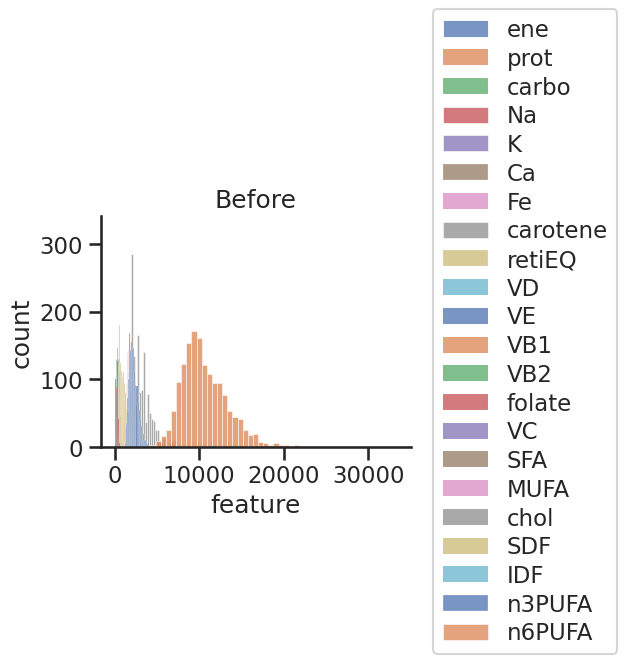

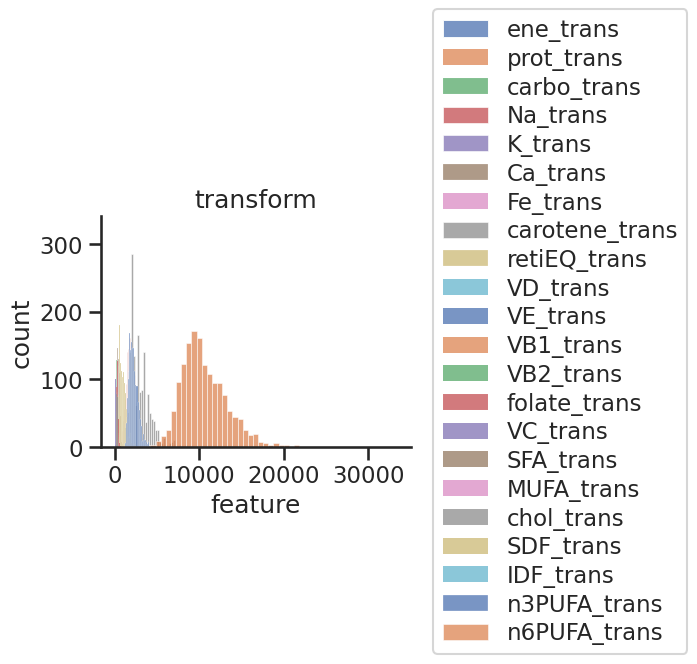

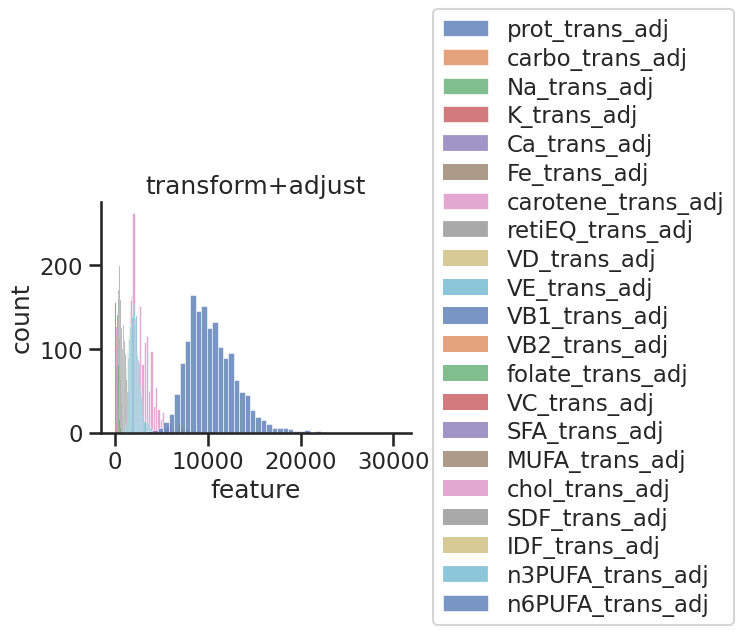

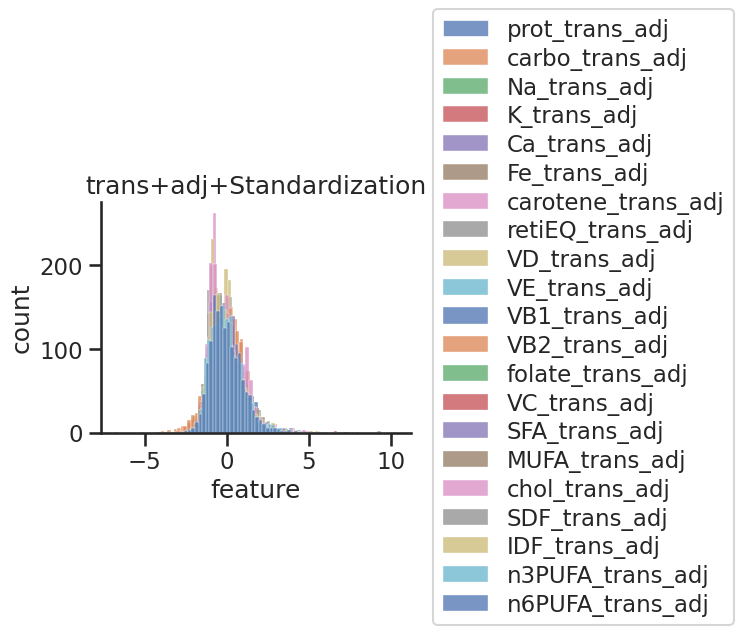

In [10]:
#Visualization
sns.set(style='ticks', context='talk')
be_DF=merged_df5_a
af1_DF=merged_df5_b
af2_DF=adjusted_df
af3_DF=adjusted_z_df
for label, tempDF in [('Before', be_DF), ('transform', af1_DF),('transform+adjust', af2_DF),('trans+adj+Standardization', af3_DF)]:
    tempDF1 = tempDF.select_dtypes(include=np.number)#Take the continous variables
    plt.figure(figsize=(4, 3))
    for col_n in tempDF1.columns:
        tempS = tempDF1[col_n]
        sns.histplot(tempS, label=col_n)
    sns.despine()
    plt.title(label)
    plt.xlabel('feature') # X軸のラベルを設定
    plt.ylabel('count')                  # Y軸のラベルを設定
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=1, labelspacing=0.25)
    plt.show()

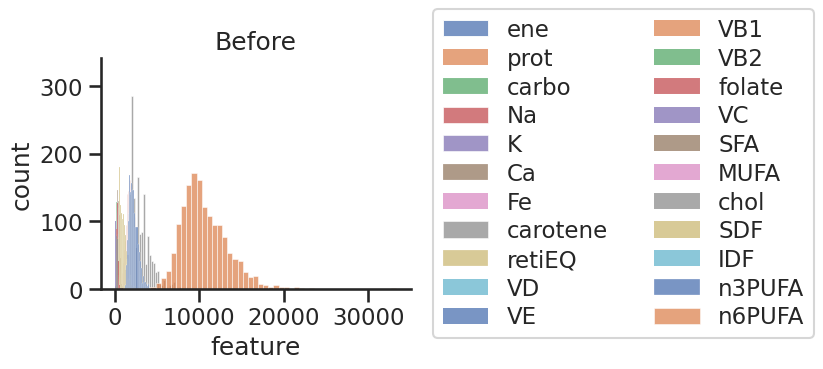

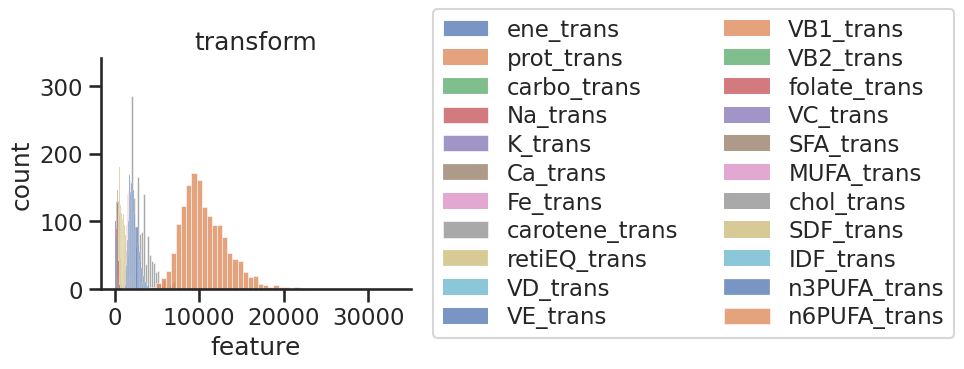

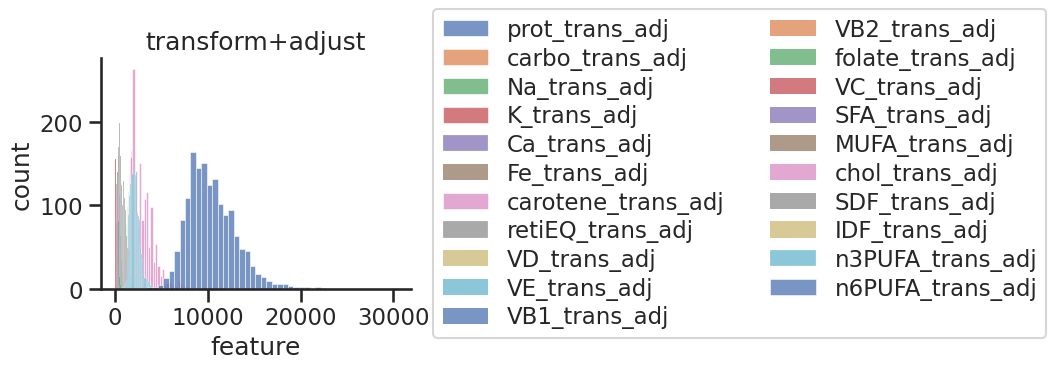

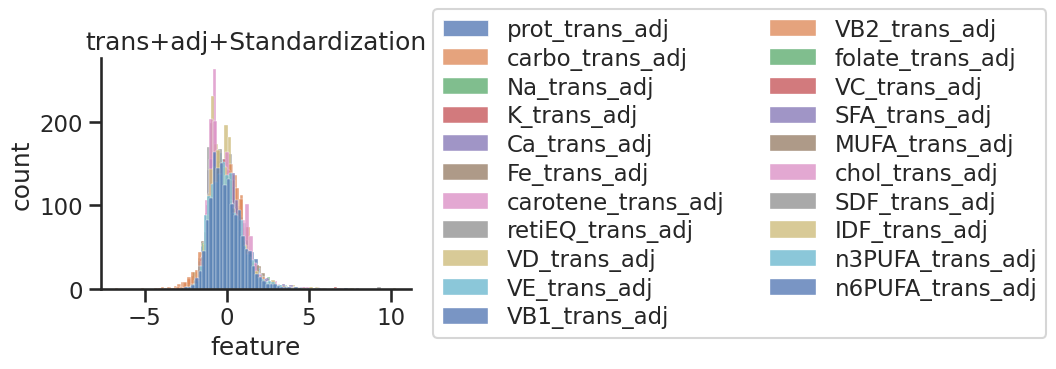

In [11]:
#Visualization
sns.set(style='ticks', context='talk')
be_DF=merged_df5_a
af1_DF=merged_df5_b
af2_DF=adjusted_df
af3_DF=adjusted_z_df
for label, tempDF in [('Before', be_DF), ('transform', af1_DF),('transform+adjust', af2_DF),('trans+adj+Standardization', af3_DF)]:
    tempDF1 = tempDF.select_dtypes(include=np.number)#Take the continous variables
    plt.figure(figsize=(4, 3))
    for col_n in tempDF1.columns:
        tempS = tempDF1[col_n]
        sns.histplot(tempS, label=col_n)
    sns.despine()
    plt.title(label)
    plt.xlabel('feature') # X軸のラベルを設定
    plt.ylabel('count')                  # Y軸のラベルを設定
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=1, labelspacing=0.25,ncols=2)
    plt.show()

グラフを nut_histograms/Before_standardization_histogram.png に保存しました。


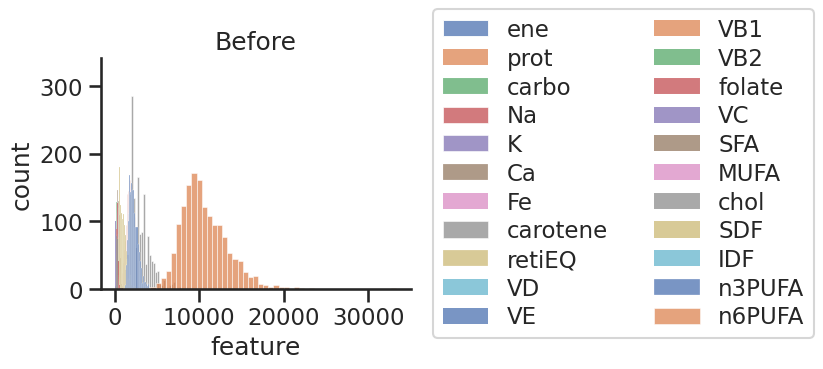

グラフを nut_histograms/transform_standardization_histogram.png に保存しました。


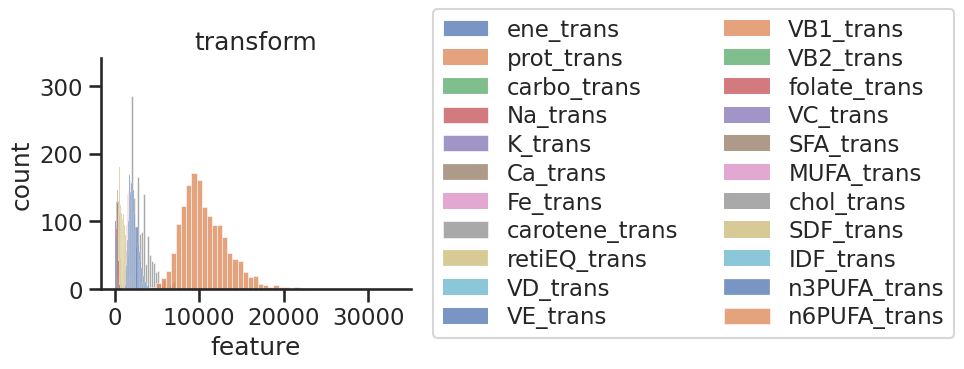

グラフを nut_histograms/transform+adjust_standardization_histogram.png に保存しました。


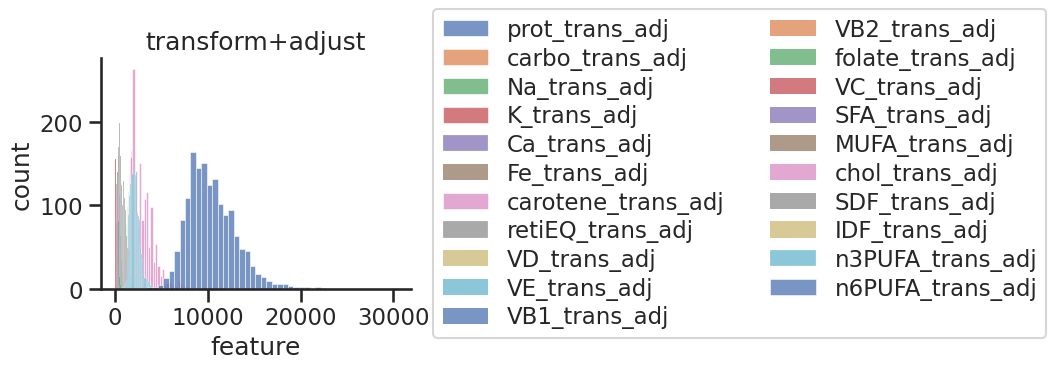

グラフを nut_histograms/trans+adj+Standardization_standardization_histogram.png に保存しました。


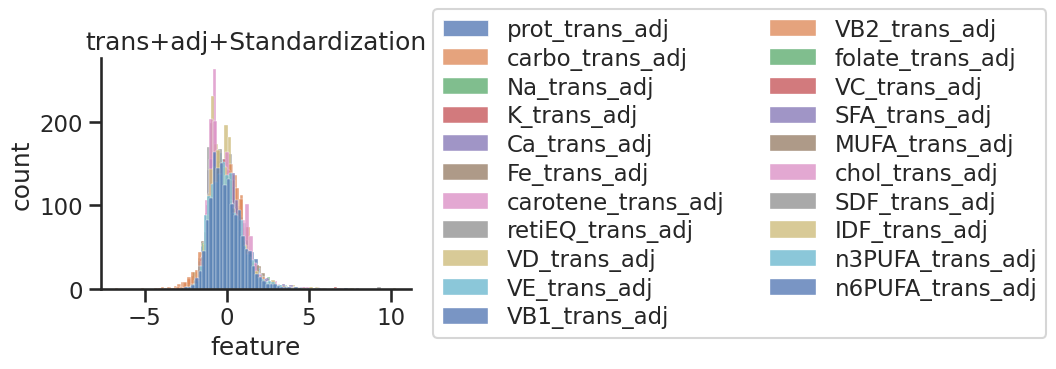

In [12]:
SAVE_DIR = 'nut_histograms'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)
    print(f"ディレクトリ '{SAVE_DIR}' を作成しました。")

# Visualization
sns.set(style='ticks', context='talk')
be_DF=merged_df5_a
af1_DF=merged_df5_b
af2_DF=adjusted_df
af3_DF=adjusted_z_df

for label, tempDF in [('Before', be_DF), ('transform', af1_DF),('transform+adjust', af2_DF),('trans+adj+Standardization', af3_DF)]:
    tempDF1 = tempDF.select_dtypes(include=np.number) # 連続変数を取得
    plt.figure(figsize=(4, 3))
    
    # プロット処理
    for col_n in tempDF1.columns:
        tempS = tempDF1[col_n]
        sns.histplot(tempS, label=col_n)
        
    sns.despine()
    plt.title(label)
    plt.xlabel('feature') # X軸のラベルを設定
    plt.ylabel('count') 
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=1, labelspacing=0.25,ncols=2)
    filename = f"{label}_standardization_histogram.png"
    save_path = os.path.join(SAVE_DIR, filename)
    plt.savefig(save_path, bbox_inches='tight', dpi=300) 
    print(f"グラフを {save_path} に保存しました。")
    
    # グラフを画面に表示
    plt.show() 
    plt.close()

## PCA実行

Percentage of variance explained by each component:


PC1     44.994095
PC2     12.081159
PC3      9.095963
PC4      6.073670
PC5      5.009887
PC6      4.039076
PC7      3.922457
PC8      3.070312
PC9      2.934098
PC10     2.619637
PC11     1.649325
PC12     1.169909
PC13     0.779394
PC14     0.711464
PC15     0.471090
PC16     0.452659
PC17     0.285586
PC18     0.271252
PC19     0.187738
PC20     0.119557
PC21     0.061674
Name: ExplainedVariance, dtype: float64

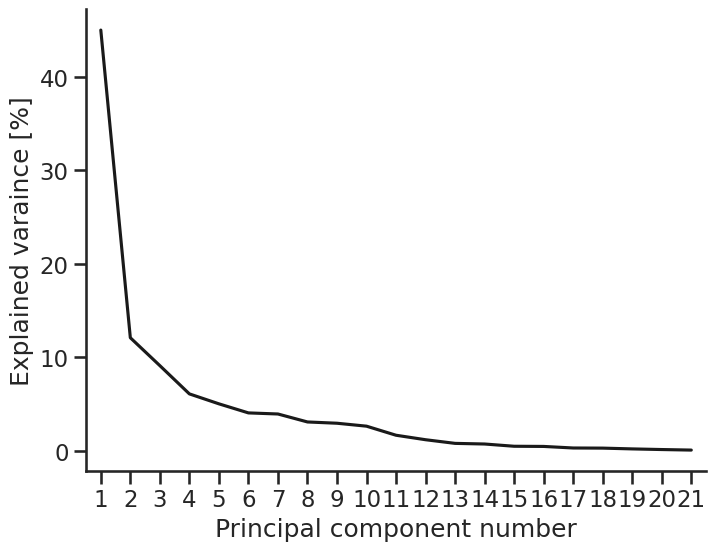

In [13]:
tempDF1 = adjusted_z_df.select_dtypes(include=np.number)#Take the continous variables
tempDF2 = adjusted_z_df.select_dtypes(exclude=np.number)#Take the categorical variables
nPCs = len(tempDF1.columns)#Calculate the same number of PCs with features

#Fit a PCA model
model = PCA(n_components=nPCs, svd_solver='randomized', iterated_power='auto', random_state=123)
model.fit(tempDF1)

#Check explained variance
tempS = pd.Series(data=model.explained_variance_ratio_*100,
                  index=['PC'+str(i+1) for i in range(nPCs)], name='ExplainedVariance')
print('Percentage of variance explained by each component:')
display(tempS)
##Scree plot
tempDF = tempS.reset_index()
tempDF['PC'] = [i+1 for i in range(nPCs)]
#sns.set(style='ticks', font='Arial', context='talk')
plt.figure(figsize=(8, 6))
p = sns.lineplot(data=tempDF, x='PC', y='ExplainedVariance', color='k')
sns.despine()
p.set(xlim=(0.5, nPCs+0.5), xticks=np.arange(1, nPCs+0.1, 1))
plt.ylabel('Explained varaince [%]')
plt.xlabel('Principal component number')
plt.show()
##Prepare PC label with the explained variance
tempL = []
for i in range(nPCs):
    rounded = Decimal(str(tempS['PC'+str(i+1)])).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
    tempL.append('PC'+str(i+1)+' ('+str(rounded)+'%)')

#Save the projected values
tempDF = pd.DataFrame(data=model.transform(tempDF1), index=tempDF1.index, columns=tempL)
pcaDF_proj = pd.merge(tempDF, tempDF2, left_index=True, right_index=True, how='left')

#Save the principal axes in feature space
pcaDF_axes = pd.DataFrame(data=model.components_, index=tempL, columns=tempDF1.columns)

In [ ]:
pcaDF_proj = pd.merge(tempDF, tempDF2, left_index=True, right_index=True, how='left')
display(pcaDF_proj)
#Save the principal axes in feature space
pcaDF_axes = pd.DataFrame(data=model.components_, index=tempL, columns=tempDF1.columns)
display(pcaDF_axes)

## 因子得点

In [ ]:
# FactorAnalyzer は既に fit 済みと仮定
fa = FactorAnalyzer(n_factors=21, rotation='varimax', method='ml')
fa.fit(adjusted_z_df)

# 1. 因子得点 (Factor Scores) の計算
factor_scores_array = fa.transform(adjusted_z_df)

# 2. 因子得点データフレームの作成
scores_df = pd.DataFrame(
    data=factor_scores_array,
    index=adjusted_z_df.index, # 元のデータのインデックスを保持
)

# 3. 因子名（Factor Labels）を列名として設定
# 以前のコードの命名規則に合わせて 'PC1' 形式で命名
n_factors = scores_df.shape[1]
scores_df.columns = [f"F{i+1}" for i in range(n_factors)]

# 4. 結果の確認
print("✅ 因子得点 (Factor Scores) データフレームの作成が完了しました。")
display(scores_df.head())

In [16]:
# scores_df を merged_df5 にマージ（列の追加）したデータフレームmerged_df6を作成。
merged_df6 = pd.concat([merged_R, pcaDF_proj], axis=1)

In [ ]:
merged_df6 = pd.concat([merged_df6,adjusted_z_df],axis=1)
pd.set_option('display.max_columns', None)
display(merged_df6)
pd.reset_option('display.max_columns')

In [ ]:
merged_df6 = merged_df6.reset_index(drop=True)
scores_df = scores_df.reset_index(drop=True)
display(scores_df)
pd.set_option('display.max_columns', None)
display(merged_df6)
pd.reset_option('display.max_columns')

## PCA処理後のVP

In [19]:
pcaDF_TN_proj=pcaDF_proj.copy()
ptnA={0:'non_cancer',1:'oral_cancer'}
pcaDF_TN_proj["TargetName"]=merged_df6["oral"].map(ptnA)

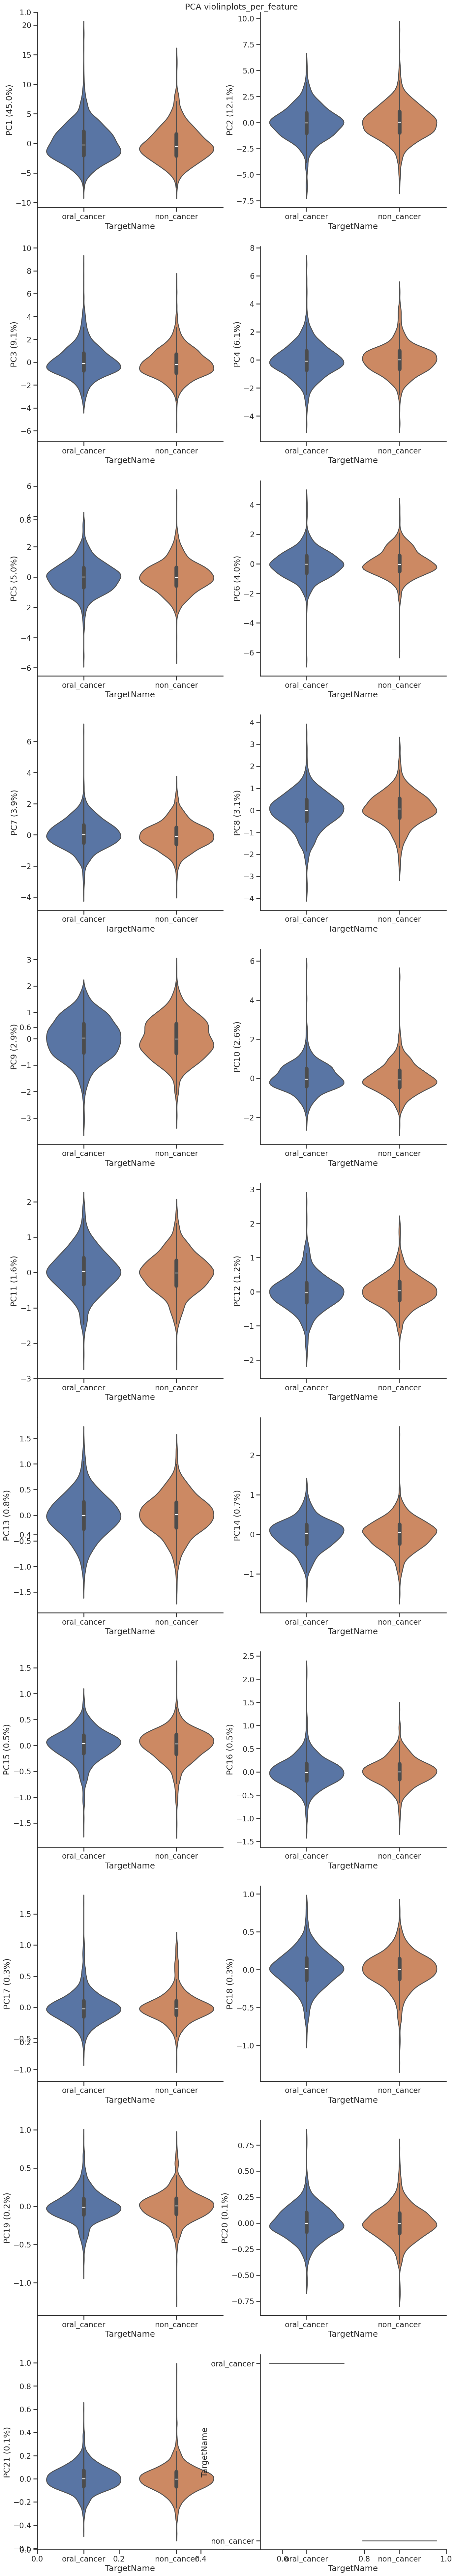

In [20]:
#Visualization: violinplots per feature
plt.figure(figsize=(16,100))
plt.title('PCA violinplots_per_feature')
for column_index, column in enumerate(pcaDF_TN_proj.columns):
    if column == 'class':
        continue
    plt.subplot(11,2, column_index+1)
    sns.violinplot(data=pcaDF_TN_proj, x='TargetName', y=column, hue='TargetName')
sns.despine()
plt.show()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re 
loadings_transposed = pcaDF_axes

clean_pc_names = loadings_transposed.index.str.replace(r'\s+\(\d+\.?\d*%\)', '', regex=True)

# Visualize contribution of each feature
topX = len(loadings_transposed.columns)#Plot all features

# ループはクリーンアップされたインデックスを使用
for pc_name_clean, pc_n_original in zip(clean_pc_names, loadings_transposed.index):
    tempDF = loadings_transposed.T
    tempDF.index.name = 'Feature'
    
    # 元のインデックス名（pc_n_original）を使ってローディング値を参照
    tempDF[pc_name_clean + '_abs'] = abs(tempDF[pc_n_original])
    tempDF = tempDF.sort_values(by=pc_name_clean + '_abs', ascending=False)
    tempDF = tempDF.iloc[:topX]
    
    # Category
    tempL = []
    for row_n in tempDF.index:
        # 元のインデックス名（pc_n_original）を使ってローディング値を参照
        if tempDF.loc[row_n, pc_n_original] > 0:
            tempL.append('Positive contribution')
        elif tempDF.loc[row_n, pc_n_original] < 0:
            tempL.append('Negative contribution')
        else:
            tempL.append('No Contribution')
    tempDF['Contribution'] = tempL
    
    # Visualization
    tempDF = tempDF.reset_index()
    
    tempD = {
        'Positive contribution':'tab:red',
        'Negative contribution':'tab:blue',
        'No Contribution':'lightgray'
    }
    
    plt.figure(figsize=(7, 6))
    # x軸にはクリーンな名前を使用
    p = sns.barplot(data=tempDF, y=pc_name_clean + '_abs', x='Feature',
                    hue='Contribution', palette=tempD, dodge=False, edgecolor='k')
    p.set(ylim=(0, 1))
    p.grid(axis='y', linestyle='--', color='black', zorder=0)
    sns.despine()
    plt.xticks(rotation=70, horizontalalignment='right', verticalalignment='center', rotation_mode='anchor')
    plt.xlabel('')
    
    # ★ 修正箇所: クリーンなPC名を使ってY軸ラベルを作成
    plt.ylabel('Contribution to ' + pc_name_clean) 
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    
    # グラフをディレクトリに保存 (ファイル名にもクリーンな名前を使用)
    file_name = f"{pc_name_clean}_feature_contribution.png"
    save_path = file_name
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()

In [22]:
adjusted_z_df.to_csv("adjusted_z_df.csv", index=False)
pcaDF_TN_proj.to_csv('pcaDF_TN_proj.csv', index=False)
merged_df6.to_csv('merged_df6.csv', index=False)

## PCA処理後のVP(性別ごと)と栄養パターンのVP（性別ごと）

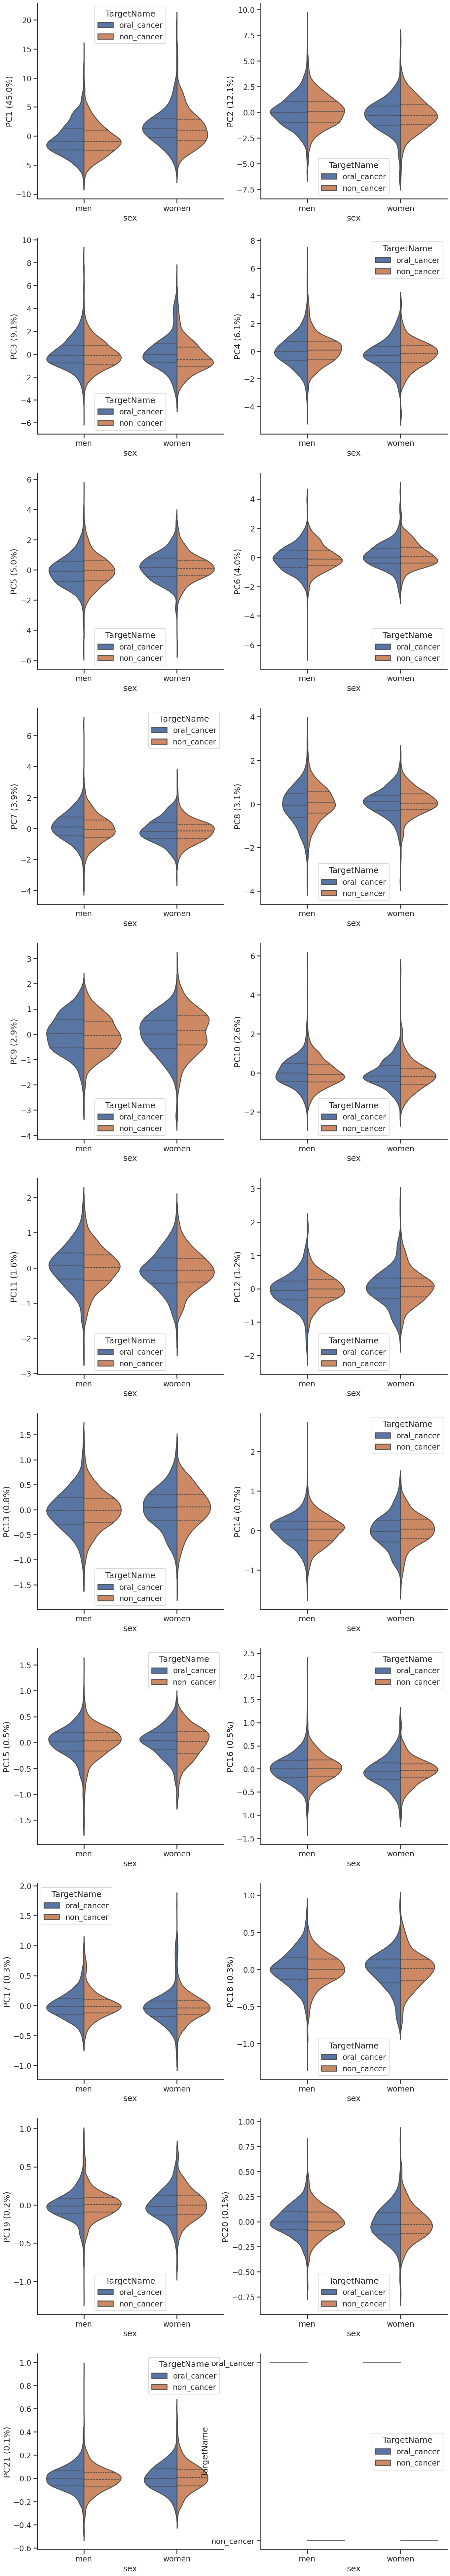

In [23]:
df = pcaDF_TN_proj

ptnB={1:'men',2:'women'}
df["sex"]=merged_df6["sex"].map(ptnB)

plt.figure(figsize=(16,100))
for column_index, column in enumerate(df.columns):
    if column == "oral" or column == "sex":
        continue
    plt.subplot(11,2, column_index+1)
    sns.violinplot(data=df, x='sex', y=column, hue='TargetName',split=True,inner='quart')
sns.despine()
plt.show()


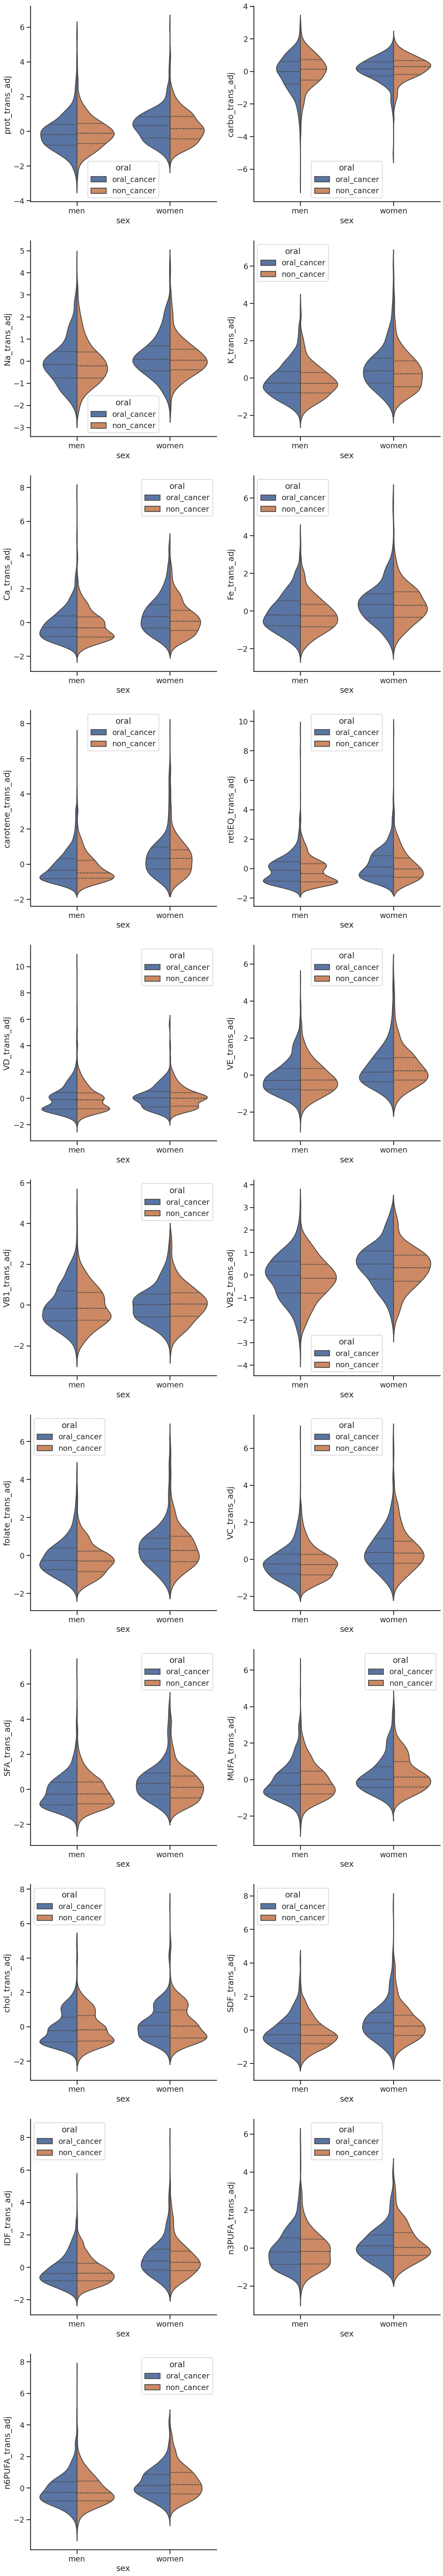

In [24]:
df = adjusted_z_df.copy()
ptnA={0:'non_cancer',1:'oral_cancer'}
df["oral"]=merged_df6["oral"].map(ptnA)
ptnB={1:'men',2:'women'}
df["sex"]=merged_df6["sex"].map(ptnB)

plt.figure(figsize=(16,100))
for column_index, column in enumerate(df.columns):
    if column == "oral" or column == "sex":
        continue
    plt.subplot(11,2, column_index+1)
    sns.violinplot(data=df, x='sex', y=column, hue='oral',split=True,inner='quart')
sns.despine()
plt.show()